# 📂 Step 2: Train / Validation / Test Split

**What we do here:**
1. Load the clean dataset from Phase 1
2. Filter out categories that are too small for training
3. Create a stratified 70/15/15 split
4. Verify the split is balanced
5. Save the splits for all future phases

**Why this matters:**
- Train set → model learns from this
- Validation set → we tune hyperparameters using this
- Test set → final honest evaluation (touched ONLY once at the end)

In [4]:
# === Cell 1: Load the clean dataset ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the clean CSV we saved in notebook 01
df = pd.read_csv("../data/processed/clean_styles.csv")
print(f"Loaded: {len(df)} rows")
print(f"Master categories: {df['masterCategory'].unique().tolist()}")
print(f"Article types: {df['articleType'].nunique()}")

Loaded: 44419 rows
Master categories: ['Apparel', 'Accessories', 'Footwear', 'Personal Care', 'Free Items', 'Sporting Goods', 'Home']
Article types: 142


In [5]:
# === Cell 2: Filter out tiny master categories ===
#
# WHY: Home (1 image), Sporting Goods (25), Free Items (105)
#       are too small to form meaningful triplets for training.
#       Triplet loss needs: (anchor, positive, negative)
#       If a category has only 1 image, there's NO positive pair.
#
# DECISION: Keep only categories with 500+ images.
#           This keeps: Apparel, Accessories, Footwear, Personal Care
#           This drops: Home (1), Sporting Goods (25), Free Items (105)

print("BEFORE filtering — Master Category counts:")
print(df['masterCategory'].value_counts())
print(f"Total: {len(df)}")

# Keep only categories with at least 500 images
MIN_MASTER_CATEGORY_SIZE = 500
category_counts = df['masterCategory'].value_counts()
valid_categories = category_counts[category_counts >= MIN_MASTER_CATEGORY_SIZE].index.tolist()

print(f"\nKeeping categories: {valid_categories}")

df = df[df['masterCategory'].isin(valid_categories)].reset_index(drop=True)

print(f"\nAFTER filtering — Master Category counts:")
print(df['masterCategory'].value_counts())
print(f"Total: {len(df)}")
print(f"Dropped: {44419 - len(df)} images")

BEFORE filtering — Master Category counts:
masterCategory
Apparel           21392
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64
Total: 44419

Keeping categories: ['Apparel', 'Accessories', 'Footwear', 'Personal Care']

AFTER filtering — Master Category counts:
masterCategory
Apparel          21392
Accessories      11274
Footwear          9219
Personal Care     2403
Name: count, dtype: int64
Total: 44288
Dropped: 131 images


In [6]:
# === Cell 3: Filter out tiny article types ===
#
# WHY: articleType is our ground truth for evaluation.
#       If an article type has only 5 images, we can't:
#       - Form enough triplets for training
#       - Have images in BOTH train AND test sets
#       - Compute meaningful Precision@K
#
# DECISION: Keep only article types with 20+ images.
#           After 70/15/15 split, that gives us:
#           ~14 in train, ~3 in val, ~3 in test (minimum)

print(f"Article types BEFORE filtering: {df['articleType'].nunique()}")

# Show what we're about to drop
MIN_ARTICLE_TYPE_SIZE = 20
article_counts = df['articleType'].value_counts()
small_types = article_counts[article_counts < MIN_ARTICLE_TYPE_SIZE]

print(f"\nArticle types with < {MIN_ARTICLE_TYPE_SIZE} images (will be dropped):")
print(small_types)
print(f"\nTotal images in small types: {small_types.sum()}")

# Keep only article types with enough images
valid_types = article_counts[article_counts >= MIN_ARTICLE_TYPE_SIZE].index.tolist()
df = df[df['articleType'].isin(valid_types)].reset_index(drop=True)

print(f"\nArticle types AFTER filtering: {df['articleType'].nunique()}")
print(f"Total images remaining: {len(df)}")

Article types BEFORE filtering: 137

Article types with < 20 images (will be dropped):
articleType
Hair Colour                  19
Rain Jacket                  18
Waist Pouch                  17
Swimwear                     17
Baby Dolls                   16
Lip Care                     16
Travel Accessory             16
Jumpsuit                     16
Waistcoat                    15
Mascara                      13
Mask and Peel                12
Booties                      12
Rompers                      12
Rucksacks                    11
Concealer                    11
Water Bottle                 11
Tights                        9
Shapewear                     9
Clothing Set                  8
Blazers                       8
Headband                      7
Salwar and Dupatta            7
Umbrellas                     6
Body Lotion                   6
Shrug                         6
Nail Essentials               6
Eye Cream                     6
Nehru Jackets                 5
Toner

In [7]:
# === Cell 4: Stratified Train/Val/Test Split ===
#
# WHAT IS STRATIFIED?
# It means each split has the SAME proportion of each articleType.
# If Tshirts = 16% of total → Train has 16%, Val has 16%, Test has 16%
#
# WHY STRATIFIED?
# Random split on imbalanced data could put ALL rare items in one set.
# Example: "Suspenders" has 21 images. Random split might put
# all 21 in train → 0 in test → can't evaluate on Suspenders.
#
# HOW: We split in 2 steps:
#   Step 1: Split into train (70%) and temp (30%)
#   Step 2: Split temp into val (50% of 30% = 15%) and test (50% of 30% = 15%)

# Step 1: 70% train, 30% temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,              # 30% goes to temp
    random_state=42,             # Reproducible split
    stratify=df['articleType']   # Keep proportions balanced
)

# Step 2: Split temp 50/50 into val and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,                    # 50% of 30% = 15% of total
    random_state=42,
    stratify=temp_df['articleType']    # Keep proportions balanced
)

# Reset indices for clean numbering
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Train set: {len(train_df)} images ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val set:   {len(val_df)} images ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set:  {len(test_df)} images ({len(test_df)/len(df)*100:.1f}%)")
print(f"Total:     {len(train_df) + len(val_df) + len(test_df)} images")

Train set: 30741 images (70.0%)
Val set:   6587 images (15.0%)
Test set:  6588 images (15.0%)
Total:     43916 images


Proportion of top 5 article types in each split:
Type                    Train %      Val %     Test %
-------------------------------------------------------
Tshirts                   16.1%      16.1%      16.1%
Shirts                     7.3%       7.3%       7.3%
Casual Shoes               6.5%       6.5%       6.5%
Watches                    5.8%       5.8%       5.8%
Sports Shoes               4.6%       4.6%       4.6%


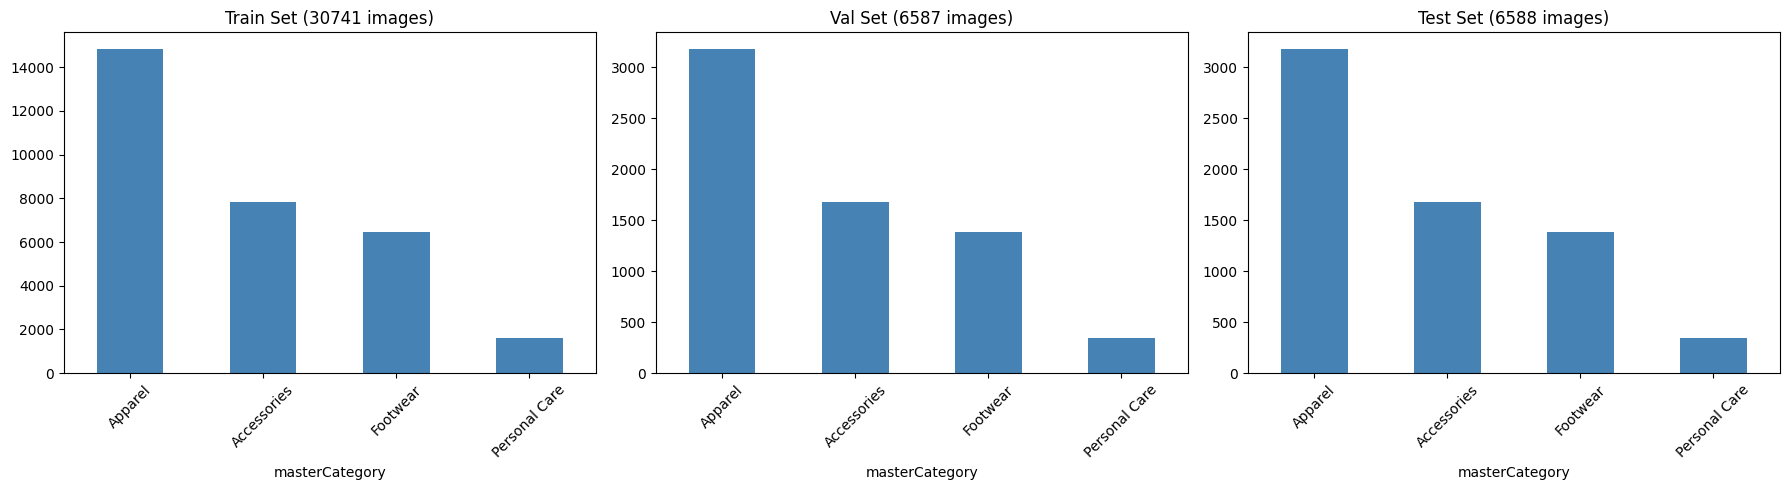

In [8]:
# === Cell 5: Verify the split is balanced ===
#
# Let's check: does each split have similar proportions?
# If stratification worked, the percentages should be nearly identical.

# Compare top 5 article types across splits
top_5 = df['articleType'].value_counts().head(5).index.tolist()

print("Proportion of top 5 article types in each split:")
print(f"{'Type':<20} {'Train %':>10} {'Val %':>10} {'Test %':>10}")
print("-" * 55)

for article_type in top_5:
    train_pct = (train_df['articleType'] == article_type).mean() * 100
    val_pct = (val_df['articleType'] == article_type).mean() * 100
    test_pct = (test_df['articleType'] == article_type).mean() * 100
    print(f"{article_type:<20} {train_pct:>9.1f}% {val_pct:>9.1f}% {test_pct:>9.1f}%")

# Visual check
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, split_df) in zip(axes, [('Train', train_df), ('Val', val_df), ('Test', test_df)]):
    split_df['masterCategory'].value_counts().plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title(f'{name} Set ({len(split_df)} images)', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [9]:
# === Cell 6: Save the splits ===
#
# We save 3 CSV files + 1 filtered master file.
# Every future notebook will load from these files.

train_df.to_csv("../data/processed/train.csv", index=False)
val_df.to_csv("../data/processed/val.csv", index=False)
test_df.to_csv("../data/processed/test.csv", index=False)

# Also save the filtered full dataset (useful for building the FAISS index later)
df.to_csv("../data/processed/filtered_styles.csv", index=False)

print("Saved files:")
print(f"  ../data/processed/train.csv           ({len(train_df)} rows)")
print(f"  ../data/processed/val.csv             ({len(val_df)} rows)")
print(f"  ../data/processed/test.csv            ({len(test_df)} rows)")
print(f"  ../data/processed/filtered_styles.csv ({len(df)} rows)")
print(f"\nArticle types in final dataset: {df['articleType'].nunique()}")
print(f"\nDone! Ready for Phase 2: Feature Extraction.")

Saved files:
  ../data/processed/train.csv           (30741 rows)
  ../data/processed/val.csv             (6587 rows)
  ../data/processed/test.csv            (6588 rows)
  ../data/processed/filtered_styles.csv (43916 rows)

Article types in final dataset: 89

Done! Ready for Phase 2: Feature Extraction.
